
Training a Classifier
=====================

This is it. You have seen how to define neural networks, compute loss and make
updates to the weights of the network.

Now you might be thinking,

What about data?
----------------

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

.. figure:: /_static/img/cifar10.png
   :alt: cifar10

   cifar10


Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

1. Loading and normalizing CIFAR10
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Using ``torchvision``, it’s extremely easy to load CIFAR10.



In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

import torch.nn as nn
import torch.nn.functional as F

!pip install torchsummary
from torchsummary import summary

# !pip install albumentations
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir
import albumentations as A
from albumentations.pytorch import ToTensorV2

%matplotlib inline

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-vyvflq04
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-vyvflq04
  Created wheel for albumentations: filename=albumentations-1.0.0-cp37-none-any.whl size=98151 sha256=58b197ed50331131f11e7d03b7685c6dd7df5a3696404831b33179f2ae331e9e
  Stored in directory: /tmp/pip-ephem-wheel-cache-w06r1jb6/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
Successfully built albumentations
  Found existing installation: albumentations 1.0.0
    Uninstalling albumentations-1.0.0:
      Successfully uninstalled albumentations-1.0.0


In [2]:
class Cifar10Dataset(torchvision.datasets.CIFAR10):
    def __init__(self, root="./data", train=True, download=True, transform=None):
        super().__init__(root=root, train=train, download=download, transform=transform)

    def __getitem__(self, index):
        image, label = self.data[index], self.targets[index]

        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]

        return image, label

In [3]:
train_transforms = A.Compose(
    [
     A.HorizontalFlip(p=0.5),
     A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
     A.CoarseDropout(max_holes = 1,
                     max_height= 16,
                     max_width= 16,
                     min_holes = 1,
                     min_height= 16,
                     min_width= 16),
     A.Normalize((0.4890062, 0.47970363, 0.47680542), (0.264582, 0.258996, 0.25643882)),
     ToTensorV2(),
    ]
)

test_transforms = A.Compose(
    [
     A.Normalize((0.4890062, 0.47970363, 0.47680542), (0.264582, 0.258996, 0.25643882)),
     ToTensorV2(),
    ]
)

In [4]:
trainset =  Cifar10Dataset('./data', train=True, download=True, transform=train_transforms)
testset = Cifar10Dataset('./data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [5]:
SEED = 1

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

print(f'CUDA available? {use_cuda}')

torch.manual_seed(SEED)

if use_cuda:
  torch.cuda.manual_seed(SEED)

CUDA available? True


In [6]:
dataloader_args = dict(shuffle=True, batch_size=32, num_workers=2, pin_memory=True)

trainloader = torch.utils.data.DataLoader(trainset, **dataloader_args)

testloader = torch.utils.data.DataLoader(testset, **dataloader_args)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

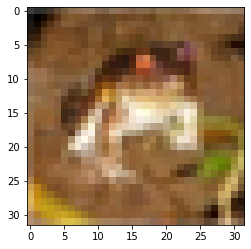

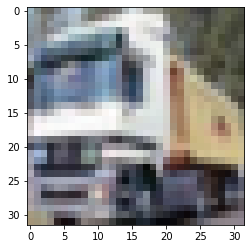

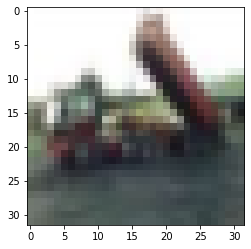

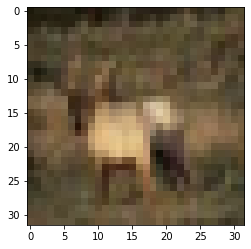

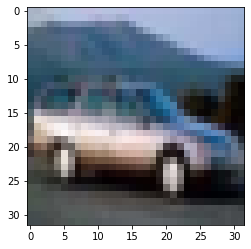

In [7]:
import matplotlib.pyplot as plt
import numpy as np

for img in trainset.data[:5]:
  plt.figure()
  plt.imshow(img)

In [32]:
cifar10_dataset = trainset.data

data_r = np.dstack([trainset.transform(cifar10_dataset[i])[:, :, 0] for i in range(len(cifar10_dataset))])
data_g = np.dstack([trainset.transform(cifar10_dataset[i])[:, :, 1] for i in range(len(cifar10_dataset))])
data_b = np.dstack([trainset.transform(cifar10_dataset[i])[:, :, 2] for i in range(len(cifar10_dataset))])
mean = np.mean(data_r), np.mean(data_g), np.mean(data_b)
std = np.std(data_r), np.std(data_g), np.std(data_b)

print(f'Training dataset shape: {trainset.data.shape}')
print(f'Training dataset mean: {mean}')
print(f'Training dataset std: {std}')

Training dataset shape: (50000, 32, 32, 3)
Training dataset mean: (0.4890062, 0.47970363, 0.47680542)
Training dataset std: (0.264582, 0.258996, 0.25643882)


In [9]:
cifar10_dataset = trainset.data

data_r = np.dstack([trainset.transform(image=cifar10_dataset[i])[:, :, 0] for i in range(len(cifar10_dataset))])
data_g = np.dstack([trainset.transform(image=cifar10_dataset[i])[:, :, 1] for i in range(len(cifar10_dataset))])
data_b = np.dstack([trainset.transform(image=cifar10_dataset[i])[:, :, 2] for i in range(len(cifar10_dataset))])
mean = np.mean(data_r), np.mean(data_g), np.mean(data_b)
std = np.std(data_r), np.std(data_g), np.std(data_b)

print(f'Training dataset shape: {trainset.data.shape}')
print(f'Training dataset mean: {mean}')
print(f'Training dataset std: {std}')

TypeError: ignored

Let us show some of the training images, for fun.



 ship  bird   cat   dog


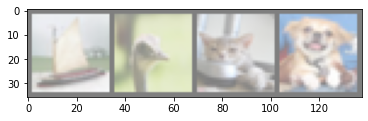

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

2. Define a Convolution Neural Network
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).


3-5-7-14 (16)-16-18-20-40 (8)-42-44-46-92 (4)-94-96-98-GAP

3-5-7-11 (32)-13-15-17-34 (16)-36-38-40-80 (8)-82-84-86-GAP

In [7]:
from cifar_model import Net
net = Net().to(device)
summary(net, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
            Conv2d-4           [-1, 64, 32, 32]          18,432
              ReLU-5           [-1, 64, 32, 32]               0
       BatchNorm2d-6           [-1, 64, 32, 32]             128
            Conv2d-7           [-1, 64, 32, 32]          36,864
              ReLU-8           [-1, 64, 32, 32]               0
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 32, 32, 32]           2,048
             ReLU-11           [-1, 32, 32, 32]               0
      BatchNorm2d-12           [-1, 32, 32, 32]              64
           Conv2d-13           [-1, 32, 30, 30]           9,216
             ReLU-14           [-1, 32,

/content/cifar_model.py:69: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


In [8]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [9]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 50
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train(model, device, trainloader, optimizer, epoch)
    test(model, device, testloader)

  0%|          | 0/1563 [00:00<?, ?it/s]

EPOCH: 1


/content/cifar_model.py:69: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
Loss=1.2468984127044678 Batch_id=1562 Accuracy=39.62: 100%|██████████| 1563/1563 [00:25<00:00, 61.33it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 1.3366, Accuracy: 5087/10000 (50.87%)

EPOCH: 2


Loss=0.9103847742080688 Batch_id=1562 Accuracy=52.95: 100%|██████████| 1563/1563 [00:25<00:00, 61.57it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 1.0691, Accuracy: 6107/10000 (61.07%)

EPOCH: 3


Loss=1.277894377708435 Batch_id=1562 Accuracy=58.46: 100%|██████████| 1563/1563 [00:25<00:00, 61.89it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 1.0612, Accuracy: 6300/10000 (63.00%)

EPOCH: 4


Loss=0.8540782332420349 Batch_id=1562 Accuracy=62.17: 100%|██████████| 1563/1563 [00:25<00:00, 61.19it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.8746, Accuracy: 6919/10000 (69.19%)

EPOCH: 5


Loss=0.7648670077323914 Batch_id=1562 Accuracy=64.77: 100%|██████████| 1563/1563 [00:25<00:00, 61.18it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.8422, Accuracy: 7037/10000 (70.37%)

EPOCH: 6


Loss=1.1272746324539185 Batch_id=1562 Accuracy=66.26: 100%|██████████| 1563/1563 [00:25<00:00, 61.12it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.7830, Accuracy: 7250/10000 (72.50%)

EPOCH: 7


Loss=0.9738679528236389 Batch_id=1562 Accuracy=68.04: 100%|██████████| 1563/1563 [00:25<00:00, 60.82it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.7488, Accuracy: 7406/10000 (74.06%)

EPOCH: 8


Loss=0.9470412731170654 Batch_id=1562 Accuracy=69.19: 100%|██████████| 1563/1563 [00:25<00:00, 60.63it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.7248, Accuracy: 7416/10000 (74.16%)

EPOCH: 9


Loss=0.8816556334495544 Batch_id=1562 Accuracy=70.58: 100%|██████████| 1563/1563 [00:25<00:00, 60.37it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.6700, Accuracy: 7647/10000 (76.47%)

EPOCH: 10


Loss=0.7745293974876404 Batch_id=1562 Accuracy=71.49: 100%|██████████| 1563/1563 [00:25<00:00, 60.75it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.6384, Accuracy: 7794/10000 (77.94%)

EPOCH: 11


Loss=0.9938163161277771 Batch_id=1562 Accuracy=72.29: 100%|██████████| 1563/1563 [00:26<00:00, 59.84it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.6228, Accuracy: 7890/10000 (78.90%)

EPOCH: 12


Loss=0.8433958888053894 Batch_id=1562 Accuracy=73.32: 100%|██████████| 1563/1563 [00:25<00:00, 60.69it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.6184, Accuracy: 7897/10000 (78.97%)

EPOCH: 13


Loss=0.6179159283638 Batch_id=1562 Accuracy=73.99: 100%|██████████| 1563/1563 [00:25<00:00, 60.13it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.5803, Accuracy: 8001/10000 (80.01%)

EPOCH: 14


Loss=0.9766788482666016 Batch_id=1562 Accuracy=74.76: 100%|██████████| 1563/1563 [00:25<00:00, 61.01it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.5582, Accuracy: 8071/10000 (80.71%)

EPOCH: 15


Loss=0.8213555216789246 Batch_id=1562 Accuracy=74.81: 100%|██████████| 1563/1563 [00:25<00:00, 60.35it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.5674, Accuracy: 8086/10000 (80.86%)

EPOCH: 16


Loss=1.2237342596054077 Batch_id=1562 Accuracy=75.47: 100%|██████████| 1563/1563 [00:25<00:00, 60.20it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.5384, Accuracy: 8140/10000 (81.40%)

EPOCH: 17


Loss=0.6163102388381958 Batch_id=1562 Accuracy=75.95: 100%|██████████| 1563/1563 [00:26<00:00, 60.00it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.5501, Accuracy: 8088/10000 (80.88%)

EPOCH: 18


Loss=0.7415136098861694 Batch_id=1562 Accuracy=76.70: 100%|██████████| 1563/1563 [00:26<00:00, 60.09it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.5480, Accuracy: 8161/10000 (81.61%)

EPOCH: 19


Loss=0.6556923389434814 Batch_id=1562 Accuracy=76.92: 100%|██████████| 1563/1563 [00:25<00:00, 60.29it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.5318, Accuracy: 8216/10000 (82.16%)

EPOCH: 20


Loss=0.4914485216140747 Batch_id=1562 Accuracy=77.56: 100%|██████████| 1563/1563 [00:26<00:00, 60.01it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.5177, Accuracy: 8242/10000 (82.42%)

EPOCH: 21


Loss=0.286507785320282 Batch_id=1562 Accuracy=77.73: 100%|██████████| 1563/1563 [00:26<00:00, 60.04it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.5156, Accuracy: 8264/10000 (82.64%)

EPOCH: 22


Loss=0.2612733244895935 Batch_id=1562 Accuracy=78.22: 100%|██████████| 1563/1563 [00:26<00:00, 59.46it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.5158, Accuracy: 8228/10000 (82.28%)

EPOCH: 23


Loss=0.7327967882156372 Batch_id=1562 Accuracy=78.39: 100%|██████████| 1563/1563 [00:26<00:00, 59.75it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.4812, Accuracy: 8337/10000 (83.37%)

EPOCH: 24


Loss=0.42099305987358093 Batch_id=1562 Accuracy=78.57: 100%|██████████| 1563/1563 [00:26<00:00, 59.97it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.5110, Accuracy: 8322/10000 (83.22%)

EPOCH: 25


Loss=0.4466497302055359 Batch_id=1562 Accuracy=78.67: 100%|██████████| 1563/1563 [00:26<00:00, 59.66it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.4706, Accuracy: 8428/10000 (84.28%)

EPOCH: 26


Loss=0.2895634174346924 Batch_id=1562 Accuracy=79.01: 100%|██████████| 1563/1563 [00:26<00:00, 59.72it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.4797, Accuracy: 8411/10000 (84.11%)

EPOCH: 27


Loss=0.9685830473899841 Batch_id=1562 Accuracy=79.28: 100%|██████████| 1563/1563 [00:26<00:00, 59.66it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.4572, Accuracy: 8481/10000 (84.81%)

EPOCH: 28


Loss=0.39777806401252747 Batch_id=1562 Accuracy=79.34: 100%|██████████| 1563/1563 [00:26<00:00, 59.92it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.4714, Accuracy: 8433/10000 (84.33%)

EPOCH: 29


Loss=0.6112797856330872 Batch_id=1562 Accuracy=79.57: 100%|██████████| 1563/1563 [00:26<00:00, 59.11it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.4659, Accuracy: 8422/10000 (84.22%)

EPOCH: 30


Loss=1.0623512268066406 Batch_id=1562 Accuracy=79.96: 100%|██████████| 1563/1563 [00:26<00:00, 59.38it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.4591, Accuracy: 8457/10000 (84.57%)

EPOCH: 31


Loss=0.8965538144111633 Batch_id=1562 Accuracy=80.47: 100%|██████████| 1563/1563 [00:26<00:00, 58.72it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.4789, Accuracy: 8436/10000 (84.36%)

EPOCH: 32


Loss=0.8842525482177734 Batch_id=1562 Accuracy=80.12: 100%|██████████| 1563/1563 [00:26<00:00, 59.28it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.4390, Accuracy: 8532/10000 (85.32%)

EPOCH: 33


Loss=0.33095240592956543 Batch_id=1562 Accuracy=80.75: 100%|██████████| 1563/1563 [00:26<00:00, 59.03it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.4419, Accuracy: 8513/10000 (85.13%)

EPOCH: 34


Loss=1.2386919260025024 Batch_id=1562 Accuracy=80.79: 100%|██████████| 1563/1563 [00:26<00:00, 58.73it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.4334, Accuracy: 8546/10000 (85.46%)

EPOCH: 35


Loss=0.7386312484741211 Batch_id=1562 Accuracy=80.91: 100%|██████████| 1563/1563 [00:26<00:00, 58.70it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.4258, Accuracy: 8564/10000 (85.64%)

EPOCH: 36


Loss=0.6028574109077454 Batch_id=1562 Accuracy=81.22: 100%|██████████| 1563/1563 [00:26<00:00, 59.31it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.4389, Accuracy: 8562/10000 (85.62%)

EPOCH: 37


Loss=0.8238955736160278 Batch_id=1562 Accuracy=81.20: 100%|██████████| 1563/1563 [00:26<00:00, 58.93it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.4395, Accuracy: 8514/10000 (85.14%)

EPOCH: 38


Loss=0.7184588313102722 Batch_id=1562 Accuracy=81.06: 100%|██████████| 1563/1563 [00:26<00:00, 58.76it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.4221, Accuracy: 8598/10000 (85.98%)

EPOCH: 39


Loss=0.5940484404563904 Batch_id=1562 Accuracy=81.25: 100%|██████████| 1563/1563 [00:26<00:00, 58.59it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.4380, Accuracy: 8494/10000 (84.94%)

EPOCH: 40


Loss=0.6948159337043762 Batch_id=1562 Accuracy=81.62: 100%|██████████| 1563/1563 [00:26<00:00, 59.06it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.4244, Accuracy: 8582/10000 (85.82%)

EPOCH: 41


Loss=0.3417942523956299 Batch_id=1562 Accuracy=81.47: 100%|██████████| 1563/1563 [00:26<00:00, 58.80it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.4284, Accuracy: 8572/10000 (85.72%)

EPOCH: 42


Loss=0.27168095111846924 Batch_id=1562 Accuracy=81.91: 100%|██████████| 1563/1563 [00:26<00:00, 58.46it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.4340, Accuracy: 8513/10000 (85.13%)

EPOCH: 43


Loss=0.6791156530380249 Batch_id=1562 Accuracy=81.81: 100%|██████████| 1563/1563 [00:26<00:00, 58.99it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.4126, Accuracy: 8608/10000 (86.08%)

EPOCH: 44


Loss=0.17831504344940186 Batch_id=1562 Accuracy=82.00: 100%|██████████| 1563/1563 [00:26<00:00, 58.30it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.4142, Accuracy: 8609/10000 (86.09%)

EPOCH: 45


Loss=0.601517379283905 Batch_id=1562 Accuracy=82.05: 100%|██████████| 1563/1563 [00:26<00:00, 57.96it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.4130, Accuracy: 8611/10000 (86.11%)

EPOCH: 46


Loss=0.2886975407600403 Batch_id=1562 Accuracy=82.25: 100%|██████████| 1563/1563 [00:26<00:00, 58.17it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.4205, Accuracy: 8593/10000 (85.93%)

EPOCH: 47


Loss=0.6943143010139465 Batch_id=1562 Accuracy=82.54: 100%|██████████| 1563/1563 [00:26<00:00, 58.81it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.4229, Accuracy: 8577/10000 (85.77%)

EPOCH: 48


Loss=0.29521873593330383 Batch_id=1562 Accuracy=82.47: 100%|██████████| 1563/1563 [00:26<00:00, 58.54it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.4108, Accuracy: 8614/10000 (86.14%)

EPOCH: 49


Loss=0.25685277581214905 Batch_id=1562 Accuracy=82.37: 100%|██████████| 1563/1563 [00:26<00:00, 58.05it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.3958, Accuracy: 8702/10000 (87.02%)

EPOCH: 50


Loss=0.6121169328689575 Batch_id=1562 Accuracy=82.68: 100%|██████████| 1563/1563 [00:26<00:00, 58.08it/s]



Test set: Average loss: 0.4172, Accuracy: 8623/10000 (86.23%)



In [15]:
import matplotlib.pyplot as plt
import numpy as np
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GroundTruth:    car  frog  bird plane


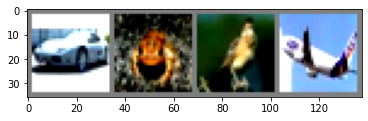

In [19]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images[:4]))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Okay, now let us see what the neural network thinks these examples above are:



In [21]:
outputs = net(images[:4].to(device))

/content/cifar_model.py:69: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


The outputs are energies for the 10 classes.
Higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [22]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    dog   cat plane   cat


The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [23]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

/content/cifar_model.py:69: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Accuracy of the network on the 10000 test images: 13 %


That looks waaay better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [24]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

/content/cifar_model.py:69: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Accuracy of plane :  0 %
Accuracy of   car : 50 %
Accuracy of  bird :  0 %
Accuracy of   cat : 74 %
Accuracy of  deer :  0 %
Accuracy of   dog :  2 %
Accuracy of  frog :  0 %
Accuracy of horse :  2 %
Accuracy of  ship :  3 %
Accuracy of truck :  0 %


Text(0.5, 1.0, 'Test Accuracy')

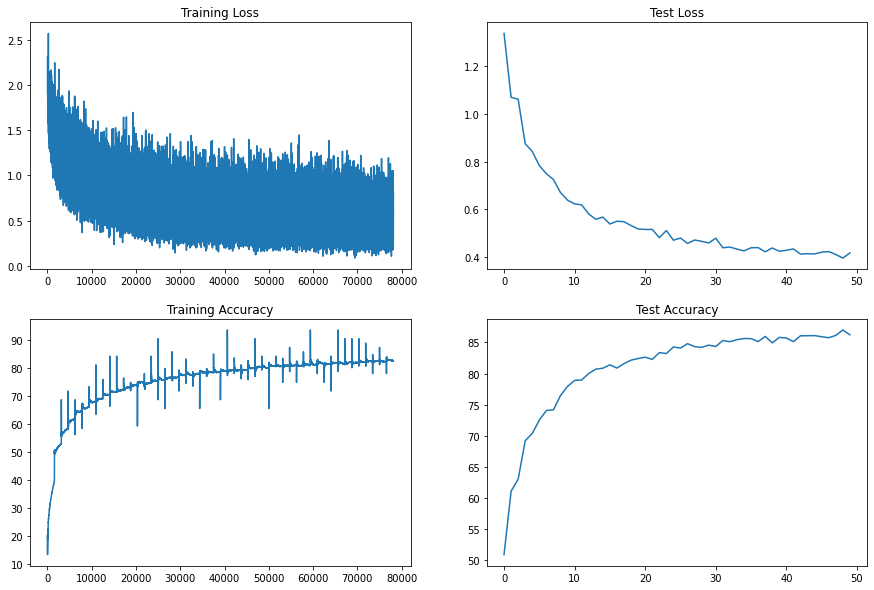

In [25]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")